In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


###**Importe de librerías**

In [ ]:
import os
import random
import time
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import torch
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
#import albumentations
#from torchvision.ops import masks_to_boxes

###**Configuración de Hiperparámetros**

In [ ]:
# número de puntos de datos considerados para calcular la pérdida o actualizar pesos que se usan en cada iteración del entrenamiento del modelo.
BATCH_SIZE = 2#1
# número de iteraciones para entrenar el modelo
NUM_EPOCHS = 10#5

# dimensiones de la imagen
WIDTH = 704
HEIGHT = 520

# Hiperparámetros necesarios para entrenar el modelo:
MOMENTUM = 0.9 # para acelerar el aprendizaje y no quedaros en mínimo local 
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.005 # para que el modelo genralice mejor. Agrega un término de penalización a la función de coste que tiene el efecto de reducir los pesos durante la retropropagación.

# Mínimo valor para que un píxel sea considerado máscaara. Por convención el límite es 0.5.
cell_type_dict = {"astro": 1, "cort": 2, "shsy5y": 3}
mask_threshold = 0.5

# Tenemos que definir el dispositivo dónde almacenamos los objetos y donde se ejecuta la red (GPU o CPU) para agilizar el proceso de aprendizaje.
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

data_path="drive/MyDrive/sartorius-cell-instance-segmentation/train/"

In [ ]:
def calculating_box_detection_per_img(df):
  '''
  cálculo del hiperparámetro BOX_DETECTIONS_PER_IMG.
  BOX_DETECTIONS_PER_IMG (int): número máximo detecciones por imagen, para todas las clases.
  Dado que el número de imágenes predeterminado es de 100, 
  ajustaremos el hiperparámetro indicado para que detecte al menos el número de células que se llega a 
  detectar en el tercer cuartil de la categoría de células con más detecciones por imagen.
  '''
  df_images = df.groupby(["id","cell_type"]).agg({'annotation': 'count'}).reset_index()
  desc = df_images.groupby(df_images.cell_type)['annotation'].describe()
  print("Cuartiles de la cantidad de células por imagen según tipo de célula:")
  display(desc)

  return(max(desc['75%']))

###**Funciones auxiliares**

In [ ]:
def split_data(data):
  '''
  creación de subconjuntos de datos en entrenamiento, validación y test y correspondientes dataframes.
  Para la correcta división de los datos hago uso de los quantiles de las anotaciones.

  devuelve: subconjuntos de datos en dataframes
  '''
  df_base = pd.read_csv(data)
  df_images = df_base.groupby(["id", "cell_type"]).agg({'annotation': 'count'}).sort_values("annotation", ascending=False).reset_index()

  # Creación de dataframes para cada subconjunto de datos creados:
  df_images_total_train, df_images_test = train_test_split(df_images, 
                                                    stratify=df_images['cell_type'], 
                                                    test_size=0.15,
                                                    random_state=1234)
  df_images_train, df_images_val = train_test_split(df_images, 
                                                    stratify=df_images['cell_type'], 
                                                    test_size=0.1,
                                                    random_state=1234)

  df_train = df_base[df_base['id'].isin(df_images_train['id'])]
  df_val = df_base[df_base['id'].isin(df_images_val['id'])]
  df_test = df_base[df_base['id'].isin(df_images_test['id'])]

  return df_train, df_val, df_test, df_images_train, df_images_val, df_images_test
  
def rle_decode(mask_rle, shape, color=1):
  '''
  Función para agilizar la tarea de segmentación de instancia con el método Run-Length encoding(RLE): 
  una forma de comprimir datos sin pérdida.
    - Los datos se comprimen:
      las secuencias del mismo dato se almacenan como el dato y su frecuencia.
      En este caso se codifica la máscara (0 para el fondo y 1 para el objecto) y se preservan los lugares de valor 1.

    - Los datos se descomprimen.

  Argumentos:
    - mask_rle: run-length as string formated (start length)
    - shape: (height, width, channels) of array to return
    - color: color for the mask
    
  Returns numpy array (mask)
  '''
  s = mask_rle.split()

  starts = list(map(lambda x: int(x) - 1, s[0::2])) # matriz de inicio que contiene una lista de índices de inicio
  lengths = list(map(int, s[1::2]))
  ends = [x + y for x, y in zip(starts, lengths)]
  if len(shape)==3:
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
  else:
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
  for start, end in zip(starts, ends):
    img[start : end] = color

  return img.reshape(shape)

def rle_encoding(x):
  '''
  Función para agilizar la tarea de segmentación de instancia con el método Run-Length encoding(RLE): 
  una forma de comprimir datos sin pérdida.
    - Los datos se comprimen:
      las secuencias del mismo dato se almacenan como el dato y su frecuencia.
      En este caso se codifica la máscara (0 para el fondo y 1 para el objecto) y se preservan los lugares de valor 1.

    - Los datos se descomprimen.

  Argumentos:
    - This function convert again convert Mask into run length encoding
  '''
  dots = np.where(x.flatten() == 1)[0]
  run_lengths = []
  prev = -2
  for b in dots:
    if (b>prev+1): 
      run_lengths.extend((b + 1, 0))
      run_lengths[-1] += 1
      prev = b
  return ' '.join(map(str, run_lengths))

In [ ]:
def remove_overlapping_pixels(mask, other_masks):
  '''
  argumentos:
  - mask: máscara
  - other_masks: lista de máscaras 

  función: elimina máscaras iguales. 
  Si una máscara de other_masks es igual que mask, la eliminamos

  devuelve: la máscara eliminada (todo Falses) o la máscara inicial (mask)
  '''
  for other_mask in other_masks:
    if np.sum(np.logical_and(mask, other_mask)) > 0:
      mask[np.logical_and(mask, other_mask)] = 0
  return mask

def get_filtered_masks(pred):
  """
  argumento:
    - pred: resultado de predicción

  función: eliminar las máscaras iguales predichas en una imagen y filtrar los píxeles 
  con menor confianza de ser predichos correctamente.

  devuelve: las máscaras filtradas de la predicción
  """
  labels_acc = []
  use_masks = []   
  for i, mask in enumerate(pred["masks"]):
    # obtengo la probabilidad de la célula de ser predicha correctamente y su clasificación
    scr = pred["scores"][i].cpu().item()
    label = pred["labels"][i].cpu().item()
    if scr > 0.5:
      mask = mask.cpu().numpy().squeeze() #retira el eje de longitud 1
      # elimino los píxeles predichos con menor confianza de ser correctos:
      binary_mask = mask > mask_threshold
      # anulo la máscara si ya está en use_masks:
      binary_mask = remove_overlapping_pixels(binary_mask, use_masks) 
      use_masks.append(binary_mask)
      labels_acc.append(label)

  return use_masks,labels_acc

def combine_masks(masks, mask_threshold):
  """
  argumentos:
    - masks: máscara
    - mask_threshold: límite inferior para que el píxel se considere predicción correcta

  función: agrupo todas las máscaras en una sola para visualizarla posteriormente

  devuelve: máscara combinada de toda la imagen con todas las células
  """
  maskimg = np.zeros((HEIGHT, WIDTH))
  for m, mask in enumerate(masks,1):
    # si el píxel es mayor que el límite propuesto lo añadimos a la máscara
    maskimg[mask>mask_threshold] = m
  return maskimg

def combine_masks_pred(masks, mask_threshold):
  """
  argumentos:
    - masks: máscara
    - mask_threshold: límite inferior para que el píxel se considere predicción correcta

  función: agrupo todas las máscaras en una sola para visualizarla posteriormente

  devuelve: máscara combinada de toda la imagen con todas las células
  """
  labels_acc = []
  maskimg = np.zeros((HEIGHT, WIDTH))
  label = masks[1]
  masks_ = masks[0]
  for m, mask in enumerate(masks_,1):
    # si el píxel es mayor que el límite propuesto lo añadimos a la máscara
    maskimg[mask>mask_threshold] = m
    labels_acc.append(label[m-1])
  return maskimg,labels_acc

In [ ]:
def analyze_train_sample(model, ds_train, sample_index):
  '''
  visualización de células y máscaras predichas y reales
  '''
  cell_type_dict = {1:"astro", 2:"cort", 3:"shsy5y"}
  img, targets = ds_train[sample_index]
  #print(img.shape)
  l = np.unique(targets["labels"])
  ig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,60), facecolor="#fefefe")
  ax[0].imshow(img.numpy().transpose((1,2,0)))
  ax[0].set_title(f"cell type {cell_type_dict[l[0]]}")
  ax[0].axis("off")
    
  masks = combine_masks(targets['masks'], 0.5)
  #plt.imshow(img.numpy().transpose((1,2,0)))
  ax[1].imshow(masks)
  ax[1].set_title(f"Ground truth, {len(targets['masks'])} labeled cells")
  ax[1].axis("off")
    
  model.eval()
  with torch.no_grad():
    preds = model([img.to(DEVICE)])[0]

  #iou
  ious_de_la_imagen = []
  for number_pred,pred in enumerate(preds['boxes'].cpu()):
    iou_max = 0
    number_truth_chosen = 0
    for number_thruth,truth in enumerate(targets['boxes']):
      iou = get_iou(truth, pred)
      if iou > 0 and iou_max < iou:
        iou_max = iou
    if iou_max > 0:
      ious_de_la_imagen.append(iou_max)
    
  removing_nans = pd.DataFrame(ious_de_la_imagen, columns=['A'])
  removing_nans2 = removing_nans.dropna(subset=['A'])
  iou_mean = removing_nans2['A'].mean()
  #
    
  #labels_pred = list(preds['labels'].cpu().numpy())

  pred_masks = combine_masks_pred(get_filtered_masks(preds), mask_threshold)
  if len(pred_masks[1]) != 0:
    count_l = pred_masks[1].count(l)
    accuracy = round(count_l/len(pred_masks[1]),3)
  else:
    accuracy = 0

  ax[2].imshow(pred_masks[0])
  ax[2].set_title(f"Predictions, {len(pred_masks[1])} predicted cells with IoU>0.5. \n {accuracy} Classification Accuracy")
  ax[2].axis("off")
  plt.show() 
    
  print("IoU media:", iou_mean)  

###**Funciones de evaluación**

In [ ]:
import math

def get_iou(boxA, boxB, epsilon=1e-5):
  '''
  obtención de métrica IoU dados dos cuadros delimitadores en formato XYXY
  '''
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])
  width = (x2 - x1)
  height = (y2 - y1)
  if (width<0) or (height <0):
        return 0.0
  area_overlap = width * height
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  area_combined = area_a + area_b - area_overlap
  if (area_combined+epsilon) >0:
    iou = area_overlap / (area_combined+epsilon) 
  if not iou>0:
      iout = 0
  return iou

def evaluate_epochs(val_mask_losses, ds_val):
  '''
  devuelve la época con mejor predicciones y las ious y pérdidas de cada época
  '''
  val_scores = pd.DataFrame()
  for e, i in enumerate(val_mask_losses):
    val_loss = np.median(i)
    model_chk = f"pytorch_model-e{e}.bin"
    print("Loading:", model_chk)
    model = get_model(len(cell_type_dict), model_chk)[0]
    model.load_state_dict(torch.load(model_chk))
    model = model.to(DEVICE)

    val_scores.loc[e,"mask_loss"] = val_loss
    mean_iou, mean_ious = iou_set(e,ds_val)
    val_scores.loc[e,"mean_iou"] = mean_iou
    val_scores.loc[e,"mean_ious_per_image"] = str(mean_ious)

    best_epoch = np.argmax(val_scores["mean_iou"])
  return best_epoch, val_scores

In [ ]:
def iou_set(e,ds_val):
  '''
  carga el modelo y predice.
  Tras predecir calcula los ious de las cajas delimitadoras tras encontrar su mejor opción de caja predicha.
  Devuelve los ious
  '''
  model.load_state_dict(torch.load(f"pytorch_model-e{e}.bin"))
  model.eval()

  media_ious = []
  for i in tqdm(range(len(ds_val))):
    img, targets = ds_val[i]
    with torch.no_grad():
      pred = model([img.to(DEVICE)])[0]
      boxes_pred = pred['boxes'].cpu() 
      boxes_truth = targets['boxes']

      ious_de_la_imagen = []
      for number_pred,pred in enumerate(boxes_pred):
        iou_max = 0
        number_truth_chosen = 0
        for number_thruth,truth in enumerate(boxes_truth):
          iou = get_iou(truth, pred)
          if math.isnan(iou):
            iou = 0
          if iou > 0 and iou_max < iou:
            iou_max = iou
        if iou_max > 0:
          ious_de_la_imagen.append(iou_max)
            
    removing_nans = pd.DataFrame(ious_de_la_imagen, columns=['A'])
    removing_nans2 = removing_nans.dropna(subset=['A'])
    iou_mean = removing_nans2['A'].mean()
        
    media_ious.append(iou_mean)
  return np.mean(media_ious), media_ious#, len(boxes_truth), len(boxes_pred)

def iou_class_bylabel(e,ds_val):
  '''
  carga el modelo y predice.
  Tras predecir calcula los ious de las cajas delimitadoras tras encontrar su mejor opción de caja predicha.
  Devuelve los ious por clase
  '''
  model.load_state_dict(torch.load(f"pytorch_model-e{e}.bin"))
  model.eval()

  media_ious_class1 = []
  media_ious_class2 = []
  media_ious_class3 = []
  class_astro_ratio = []
  class_cort_ratio = []
  class_shsy5y_ratio = []

  for i in tqdm(range(len(ds_val))):
    img, targets = ds_val[i]
    belonging_class = np.array(targets['labels'].cpu())[0]
    with torch.no_grad():
        pred = model([img.to(DEVICE)])[0]
        boxes_pred = pred['boxes'].cpu() 
        boxes_truth = targets['boxes']
        classes_pred = pred['labels'].cpu().numpy()
        classes_truth = targets['labels'].cpu().numpy()

        ious_de_la_imagen = []
        for number_pred,pred in enumerate(boxes_pred):
          iou_max = 0
          number_truth_chosen = 0
          for number_thruth,truth in enumerate(boxes_truth):
            iou = get_iou(truth, pred)
            if math.isnan(iou):
              iou = 0
            if iou > 0 and iou_max < iou:
              iou_max = iou
          if iou_max > 0:
            ious_de_la_imagen.append(iou_max)
            
    removing_nans = pd.DataFrame(ious_de_la_imagen, columns=['A'])
    removing_nans2 = removing_nans.dropna(subset=['A'])
    iou_mean = removing_nans2['A'].mean()

    if belonging_class == 1: #astro
      media_ious_class1.append(iou_mean)
      pred_correct = (np.count_nonzero(classes_pred == 1),len(classes_pred))
      if len(classes_pred) == 0:
        class_astro_ratio.append(0)
      else:
        class_astro_ratio.append(round(pred_correct[0]/pred_correct[1],2))

    elif belonging_class == 2: #cort
      media_ious_class2.append(iou_mean)
      pred_correct = (np.count_nonzero(classes_pred == 1),len(classes_pred))
      if len(classes_pred) == 0:
        class_astro_ratio.append(0)
      else:
        class_cort_ratio.append(round(pred_correct[0]/pred_correct[1],2))

    else:
      media_ious_class3.append(iou_mean) #shsy5y
      pred_correct = (np.count_nonzero(classes_pred == 1),len(classes_pred))
      if len(classes_pred) == 0:
        class_astro_ratio.append(0)
      else:
        class_shsy5y_ratio.append(round(pred_correct[0]/pred_correct[1],2))

  return media_ious_class1, media_ious_class2, media_ious_class3,\
           class_astro_ratio, class_cort_ratio, class_shsy5y_ratio

###**Preprocesamiento de datos**

In [ ]:
class CellDataset(Dataset):
  '''
  Esta clase deriva de la clase importada en pytorch: Dataset (por lo que hay que definir init,  getitem y len).
  Esta clase almacena los datos para poder obtener un punto de datos a la vez.

  argumentos:
    - image_dir: ruta de las imágenes
    - df: dataframe
    - transform: si es el conjunto de entrenamiento aplicamos la función get_transform
  '''
  def __init__(self, df, round_id, transforms=None):
    self.transforms = transforms # aplicamos la función get_transform
    self.df = df
    self.dfdict = self.df.to_dict('index')
    self.round_id = round_id

  def __getitem__(self, idx):
    # idx hace referencia al índice de la fila que se va a obtener del conjunto de datos.
    df_dict = self.dfdict[idx]
    img_path = os.path.join(data_path, df_dict['id'] + '.png')
        
    # cargamos la imagen
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

    # creamos los cuadros delimitadores y máscaras para cada imagen
    boxes = []
    masks = np.zeros((len(df_dict['annotation']), df_dict['height'], df_dict['width']), dtype=np.uint8)
    for i, annot in enumerate(df_dict['annotation']):
      rle = rle_decode(annot, (df_dict['height'], df_dict['width']))

      mask = np.array(rle) > 0
      masks[i, :, :] = mask
      
      boxes.append(get_box(mask))
        
    # Mask R-CNN requiere un target donde almacenemos los datos de cada imagen en un diccionario, convertimos a tensores
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = [int(df_dict["cell_type"]) for _ in range(len(df_dict['annotation']))]
    target = {
            'boxes': boxes,
            'labels': torch.as_tensor(labels, dtype=torch.int64),
            'masks': torch.as_tensor(masks, dtype=torch.uint8),
            'image_id': torch.tensor([idx + self.round_id]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((len(df_dict['annotation']),), dtype=torch.int64)
             }

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
      # número de puntos de datos
    return len(self.dfdict)

# Transformaciones horizontal y vertical para hacer data augmentation
class Compose:
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, image, target):
    for t in self.transforms:
      image, target = t(image, target)
    return image, target

class VerticalFlip:
  def __init__(self, prob):
    self.prob = prob

  def __call__(self, image, target):
    if random.random() < self.prob:
      height, width = image.shape[-2:]
      image = image.flip(-2)
      bbox = target["boxes"]
      bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
      target["boxes"] = bbox
      target["masks"] = target["masks"].flip(-2)
    return image, target

class HorizontalFlip:
  def __init__(self, prob):
    self.prob = prob

  def __call__(self, image, target):
    if random.random() < self.prob:
      height, width = image.shape[-2:]
      image = image.flip(-1)
      bbox = target["boxes"]
      bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
      target["boxes"] = bbox
      target["masks"] = target["masks"].flip(-1)
    return image, target
'''
class crop:
  def __init__(self, prob):
    self.prob = prob

  def __call__(self, image, target):
    if random.random() > 0.5:
      resize_tuple= (515,700)
      i, j, h, w = torchvision.transforms.RandomCrop.get_params(image, output_size=resize_tuple)
      image = F.crop(image, i, j, h, w)
      mask = F.crop(target['masks'], i, j, h, w)
      mask_bool = mask>0
      box = masks_to_boxes(mask_bool)

      target['masks'] = mask
      target['boxes']= box
  return image, target
'''
'''
#IMPOSIIBLE HACER UNA ROTACIIÓON
class Rotate_alb:
  def __init__(self,prob):
    self.prob=prob
  def __call__(self,image,target):
    ''''''
    image = image.permute(1, 2,0)

    a = albumentations.Compose([albumentations.ShiftScaleRotate(rotate_limit=10,p=0.5)],p=1)
    rotate = a(image=image.numpy(), 
                  masks=[target['masks'].numpy()])
    img = rotate['image']
    nm = rotate['masks']
    ''''''
    angle = random.randint(0, 180)
    if random.random() < self.prob:
      rotater = torchvision.transforms.RandomRotation(degrees=(0, 180))
      angle = get_params(rotater.degrees)
      #rotater = F.rotate(image, angle)
      image = rotater(image)
      nb =rotater(target['boxes'])
      nm = rotater(target["masks"])
    ##
      nm_tensor=torch.as_tensor(nm, dtype=torch.uint8)

      nm_tensor = nm_tensor.squeeze()
      nm_bool=nm_tensor>0

      nb = masks_to_boxes(nm_bool)

      target['masks'] = nm_tensor#torch.as_tensor(nm, dtype=torch.uint8)
      target['boxes'] = nb#torch.as_tensor(nb, dtype=torch.float32)
      print('finished one image....')
    #print('image size is',F.to_tensor(img).size())
    return F.to_tensor(image), target
'''
class presets:
  '''
  ajuste de brillo, saturación, contraste
  '''
  def __call__(self,image,target):
    image= F.adjust_brightness(image,0.8)
    image = F.adjust_contrast(image,3)
    image = F.adjust_saturation(image,3)
    return image, target


class ToTensor:
  def __call__(self, image, target):
    image = F.to_tensor(image)
    return image, target
    
def get_transform(train):
  transforms = [ToTensor()]
  # Data augmentation para el entrenamiento
  if train: 
    transforms.append(HorizontalFlip(0.7))
    transforms.append(VerticalFlip(0.6))
    transforms.append(presets())
    #transforms.append(Rotate_alb(1))
    #transforms.append(crop(0.9))
  return Compose(transforms)

In [ ]:
def get_box(mask):
  '''
  obtenemos el cuadro delimitador de una máscara
  '''
  pos = np.where(mask) # encontramos la posición dnode mask=1
  xmin = np.min(pos[1]) # la mínima posición nos dará las coordenadas mínimas
  xmax = np.max(pos[1]) # la máxima posición nos dará las coordenadas máximas
  ymin = np.min(pos[0])
  ymax = np.max(pos[0])
  return [xmin, ymin, xmax, ymax]

In [ ]:
def get_data(df, batch_size, training=False):
  '''
  argumentos:
  - data_path: ruta de acceso a imágenes
  - df: dataframe sobre el que crear una instancia de la clase CellDatast
  - transform_train: True o False si queremos o no crear data augmentation en los datos de entrenamiento
  - batch_size: número de puntos de datos que agruparemos
  - resize: ajuste de las dimensiones de las imágenes

  devuelve: instancia de clase CellDataset y DataLoader

  objetivo: cargar y procesar los datos e imágenes como fuente de entrada correcta para poder ser entrenados
  '''
  # modificamos el dataframe para poder instanciarlo como clase CellDataset
  new_df = df.groupby(["id", "cell_type","width","height"])['annotation'].agg(lambda x: list(x)).reset_index() 
  new_df['cell_type'] = new_df['cell_type'].apply(lambda x: int(cell_type_dict[x])) 

  if training:
    ds00 = CellDataset(new_df, 0, get_transform(train=False))
    ds0 = CellDataset(new_df, 100000, get_transform(train=True))
    ds1 = CellDataset(new_df[new_df['cell_type'] == 3].reset_index(), 200000, get_transform(train=True))#shsy5y
    ds2 = CellDataset(new_df[new_df['cell_type'] == 1].reset_index(), 300000, get_transform(train=True))#astro
    ds3 = CellDataset(new_df[new_df['cell_type'] == 3].reset_index(), 300000, get_transform(train=True))#shsy5y
    ds4 = CellDataset(new_df[new_df['cell_type'] == 1].reset_index(), 400000, get_transform(train=True))#astro
    ds = torch.utils.data.ConcatDataset([ds00,ds0,ds1,ds2,ds3,ds4])
  else:
    ds = CellDataset(new_df,400000,get_transform(train=False))
  # La clase DataLoader nos ayuda a preparar los datos para la red neuronal definiendo el dataset con el que trabajar, el batch, si la muestra es aleatoria, etc.
  dl = DataLoader(ds, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=lambda x: tuple(zip(*x)))
  return dl, ds

###**Estructura Red Neuronal**

In [ ]:
def get_model(num_classes, model_chkpt=None):   
  '''
  argumentos: 
    - num_clases: número de clases a predecir
    - model_chkpt: carga del modelo entrenado guardado anteriormente
    
  objetivo: definir el modelo y optimizador 

  devuelve: el modelo y el optimizador
  ''' 
  # Cargamos un modelo de segmentación de instancias previamente entrenado en COCO (transfer learning)
  model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1',
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG)

  # obtenemos el número de características de entrada para el clasificador
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # y reemplazamos la cabeza preentrenada con una nueva
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

  # obtenemos el número de características de entrada para el clasificador de máscara
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  # y reemplazamos la cabeza preentrenada con una nueva
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes+1)

  if model_chkpt:
    # carga de modelos en PyTorch
    model.load_state_dict(torch.load(model_chkpt, map_location=DEVICE))
        
  # Registramos el modelo en el dispositivo GPU or CPU
  model.to(DEVICE)

  # Es necesario calcular los gradientes para este tensor para optimizar los pesos:
  for param in model.parameters():
    param.requires_grad = True 

  params = [p for p in model.parameters() if p.requires_grad]

  # Definimos el optimizador (SGD) que determinará cómo irán cambiando los pesos
  optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  #optimizer = torch.optim.Adam(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

  return model, optimizer

In [ ]:
def train_batch(batch_idx, images, targets, model, n_batches, train=False):
  '''
  argumentos: 
  - batch_idx: número del lote
  - images y targets: puntos de datos (imágenes y sus correspondientes datos)
  - model: modelo para ser entrenado
  - n_batches: longitud conjunto de datos
  - train: True o False si los puntos de datos son de entrenamiento o no
  
  función: calcular las pérdidas (total, de la máscara, de la clase) de un lote. Entrenará los puntos de datos escogidos
  devuelve: todas las pérdidas
  '''
  # Carga las imágenes y los targets en listas
  images = list(image.to(DEVICE) for image in images)
  targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

  # Devuelve las pérdidas: pérdida de clase, pérdida del cuadro delimitador y pérdida de la máscara
  loss = model(images, targets) # Devuelve pérdida y detecciones

  # Sumamos todas las pérdidas para obtener la pérdida total
  total_losses = sum(losses for losses in loss.values())
  real_total_losses = (loss['loss_mask'].item() * 0.5) + (loss['loss_box_reg'].item() * 0.4) + (loss['loss_classifier'].item() * 0.1)
  if train:
    # Una vez que tengamos la pérdida, podemos actualizar los pesos usando retropropagación
    total_losses.backward()
    optimizer.step()
    # Vaciamos la memoria de gradientes para el próximo lote    
    optimizer.zero_grad()

  # Logging
  # Acumulo el valor de pérdida de la máscara, de clasificación y de pérdida total
  loss_mask = loss['loss_mask'].item()
  loss_class = loss['loss_classifier'].item()
  real_total_loss = (loss['loss_mask'].item() * 0.5) + (loss['loss_box_reg'].item() * 0.4) + (loss['loss_classifier'].item() * 0.1)
  ttl_loss = total_losses.item()
        
  return real_total_loss, ttl_loss, loss_mask, loss_class

In [ ]:
def train_one_epoch(model, optimizer, dl_train, dl_val):
  '''
  argumentos:
  - model: modelo
  - optimizer: optimizador
  - dl_train: DataLoader entrenamiento
  - dl_val: DataLoader validación

  función: entrenar el modelo una época
  devuelve: las pérdidas totales, de clase, de la máscara
  '''
  n_batches=len(dl_train)
  n_batches_val=len(dl_val)

  # lr_scheduler: método para ajustar la tasa de aprendizaje en función del número de épocas.
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
  
  # listas que contendrán los valores de precisión y pérdida correspondientes a cada lote dentro de una época
  train_epoch_total_losses, val_epoch_total_losses = [], []
  train_epoch_mask_losses, val_epoch_mask_losses = [], []
  train_epoch_class_losses, val_epoch_class_losses = [], []
  real_train_epoch_total_losses, real_val_epoch_total_losses = [], []

  time_start = time.time()
  # Entrenamos el modelo   
  model.train()

  # Loop de entrenamiento:
  # Se crean lotes de datos de entrenamiento iterando a través del DataLoader (dl_train)
  # Entrena el lote y almacenamos los valores de las pérdidas 
  for batch_idx, (images, targets) in enumerate(dl_train, 1):
    real_train_loss, train_loss, train_loss_mask,  train_loss_class = \
        train_batch(batch_idx, images, targets, model, n_batches, train=True)
    train_epoch_total_losses.append(train_loss)
    train_epoch_mask_losses.append(train_loss_mask)
    train_epoch_class_losses.append(train_loss_class)
    real_train_epoch_total_losses.append(real_train_loss)

  lr_scheduler.step()

  # Repetimos el proceso para dl_val (validación) sin calcular el gradiente 
  with torch.no_grad(): # deshabilita el cálculo de gradiente
    for batch_idx, (images, targets) in enumerate(dl_val, 1):
      real_val_loss, val_loss, val_loss_mask,  val_loss_class = \
        train_batch(batch_idx, images, targets, model, n_batches, train=False)
      val_epoch_total_losses.append(val_loss)
      val_epoch_mask_losses.append(val_loss_mask)
      val_epoch_class_losses.append(val_loss_class)
      real_val_epoch_total_losses.append(real_val_loss)

  elapsed = time.time() - time_start

  # guardamos el modelo de esta época para poder cargarlo de nuevo tras el entrenamiento
  torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")

  prefix = f"[Epoch {epoch:2d} / {NUM_EPOCHS:2d}]"
  print(prefix)
  print(f"{prefix} Train mask-only loss: {np.median(train_epoch_mask_losses)}, Train classifier loss {np.median(train_epoch_class_losses)}")
  print(f"{prefix} Val mask-only loss  : {np.median(val_epoch_mask_losses)}, Val classifier loss {np.median(val_epoch_class_losses)}")
  print(prefix)
  print(f"{prefix} Train loss: {np.median(train_epoch_total_losses)}. Val loss: {np.median(val_epoch_total_losses)} [{elapsed:.0f} secs]")
  # {train_loss_accum / n_batches:7.3f}
  print(prefix)

  return  real_train_epoch_total_losses, train_epoch_total_losses,train_epoch_mask_losses,train_epoch_class_losses,\
          real_val_epoch_total_losses, val_epoch_total_losses,val_epoch_mask_losses,val_epoch_class_losses

###**Carga de datos**

In [ ]:
#Initialize the model, loss, optimizer, and DataLoaders:
# Get data
df_train, df_val, df_test, df_images_train, df_images_val, df_images_test = split_data(f"drive/MyDrive/sartorius-cell-instance-segmentation/train.csv")

train_sample_ids = ['fe3e30f849f4', '042c17cd9143', #shsy5y
                '0140b3c8f445', '08f52aa2add3', #astro
                '01ae5a43a2ab', '026b3c2c4b32','029e5b3b89c7' #cort
               ] 
train_sample = df_train[df_train.id.isin(train_sample_ids)]

val_sample_ids = ['042dc0e561a4', '15283b194621', #shsy5y
              '1395c3f12b7c', '2be2ec84ac11', #astro
              '049f02e0f764', '14dbd973a7cd', '16e538bbe8c5',#cort
              ]
val_sample = df_val[df_val.id.isin(val_sample_ids)]

# Cálculo de hipeparámetro box_detections_per_img:
BOX_DETECTIONS_PER_IMG = int(calculating_box_detection_per_img(df_train))

data_path = f"drive/MyDrive/sartorius-cell-instance-segmentation/train"
dl_train, ds_train = get_data(train_sample,batch_size=BATCH_SIZE,training=True)
dl_val, ds_val = get_data(val_sample,batch_size=BATCH_SIZE)

Cuartiles de la cantidad de células por imagen según tipo de célula:


,count,mean,std,min,25%,50%,75%,max
cell_type,,,,,,,,
astro,118.0,80.313559,66.683805,5.0,50.00,70.5,98.5,594.0
cort,288.0,33.711806,16.416304,4.0,23.75,30.5,39.0,108.0
shsy5y,139.0,338.553957,149.930765,49.0,239.50,324.0,429.0,790.0


###**Cálculo de pérdidas en entrenamiento y validación antes de entrenar la red neuronal**

In [ ]:
def no_train_model(dl):
  model_ = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1',
                                                                    box_detections_per_img=BOX_DETECTIONS_PER_IMG)

  # obtenemos el número de características de entrada para el clasificador
  in_features = model_.roi_heads.box_predictor.cls_score.in_features
  # y reemplazamos la cabeza preentrenada con una nueva
  model_.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3+1)

  # obtenemos el número de características de entrada para el clasificador de máscara
  in_features_mask = model_.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  # y reemplazamos la cabeza preentrenada con una nueva
  model_.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 3+1)
  model_.to(DEVICE)

  ttl_loss = []
  for batch_idx, (images, targets) in enumerate(dl, 1):
      images = list(image.to(DEVICE) for image in images)
      targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

      #with torch.no_grad():
      #if torch.cuda.is_available():
      model_.cuda()
      loss = model_(images, targets) 
      total_losses = (loss['loss_mask'].item() * 0.5) + (loss['loss_box_reg'].item() * 0.4) + (loss['loss_classifier'].item() * 0.1) #sum(losses for losses in loss.values())
      ttl_loss.append(total_losses)
      
  return ttl_loss

In [ ]:
ttl_loss_train = no_train_model(dl_train)
ttl_loss_val = no_train_model(dl_val)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth


  0%|          | 0.00/177M [00:00<?, ?B/s]

###**Ejecución del modelo**

In [ ]:
# Model and optimizer
model, optimizer = get_model(len(cell_type_dict))

# Initialize the lists that contain loss values over increasing epochs:
trn_total_losses = []
val_total_losses = []
trn_mask_losses = []
val_mask_losses = []
trn_class_losses = []
val_class_losses = []
trn_real_total_losses = []
val_real_total_losses = []

In [ ]:
# Loop through five epochs and initialize lists that contain accuracy and loss
#across batches of training data within a given epoch:
NUM_EPOCHS=5
for epoch in range(NUM_EPOCHS):
  print(epoch)
  real_train_epoch_total_losses, train_epoch_total_losses,train_epoch_mask_losses,train_epoch_class_losses,\
  real_val_epoch_total_losses, val_epoch_total_losses,val_epoch_mask_losses,val_epoch_class_losses = \
  train_one_epoch(model, optimizer, dl_train, dl_val)

  trn_total_losses.append(train_epoch_total_losses)
  val_total_losses.append(val_epoch_total_losses)

  trn_mask_losses.append(train_epoch_mask_losses)
  val_mask_losses.append(val_epoch_mask_losses)

  trn_class_losses.append(train_epoch_class_losses)  
  val_class_losses.append(val_epoch_class_losses)

  trn_real_total_losses.append(real_train_epoch_total_losses)
  val_real_total_losses.append(real_val_epoch_total_losses)


0
[Epoch  0 /  5]
[Epoch  0 /  5] Train mask-only loss: 0.9523412585258484, Train classifier loss 0.8820040225982666
[Epoch  0 /  5] Val mask-only loss  : 0.6657234728336334, Val classifier loss 0.6572020947933197
[Epoch  0 /  5]
[Epoch  0 /  5] Train loss: 3.912405490875244. Val loss: 2.4470781087875366 [19 secs]
[Epoch  0 /  5]
1
[Epoch  1 /  5]
[Epoch  1 /  5] Train mask-only loss: 0.5632007122039795, Train classifier loss 0.7513859868049622
[Epoch  1 /  5] Val mask-only loss  : 0.5347532629966736, Val classifier loss 0.654331773519516
[Epoch  1 /  5]
[Epoch  1 /  5] Train loss: 2.5041306018829346. Val loss: 2.2765005826950073 [19 secs]
[Epoch  1 /  5]
2
[Epoch  2 /  5]
[Epoch  2 /  5] Train mask-only loss: 0.49954673647880554, Train classifier loss 0.6513031125068665
[Epoch  2 /  5] Val mask-only loss  : 0.4863821119070053, Val classifier loss 0.5797215700149536
[Epoch  2 /  5]
[Epoch  2 /  5] Train loss: 2.207926034927368. Val loss: 2.0795416831970215 [19 secs]
[Epoch  2 /  5]
3
[

###**Evaluación del modelo**

####**1. Análisis de Pérdidas**

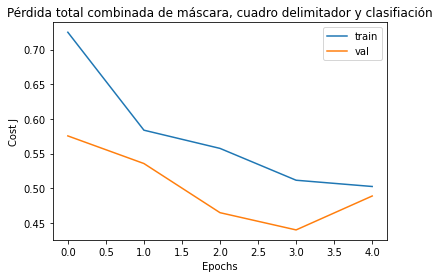

In [ ]:
plt.plot([np.median(i) for i in trn_real_total_losses], label='train')
plt.plot([np.median(i) for i in val_real_total_losses], label='val')
#plt.plot(np.median(ttl_tr_loss), label='default train loss', marker=".", color='r')
#plt.plot(np.median(ttl_vl_loss), label='default val loss', marker=".", color='g')
plt.title('Pérdida total combinada de máscara, cuadro delimitador y clasifiación')
plt.ylabel('Cost J')
plt.xlabel('Epochs')
plt.legend()
plt.show()

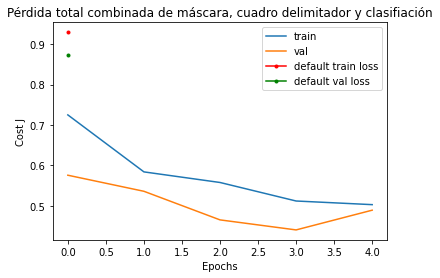

In [ ]:
plt.plot([np.median(i) for i in trn_real_total_losses], label='train')
plt.plot([np.median(i) for i in val_real_total_losses], label='val')
plt.plot(np.median(ttl_loss_train), label='default train loss', marker=".", color='r')
plt.plot(np.median(ttl_loss_val), label='default val loss', marker=".", color='g')
plt.title('Pérdida total combinada de máscara, cuadro delimitador y clasifiación')
plt.ylabel('Cost J')
plt.xlabel('Epochs')
plt.legend()
plt.show()

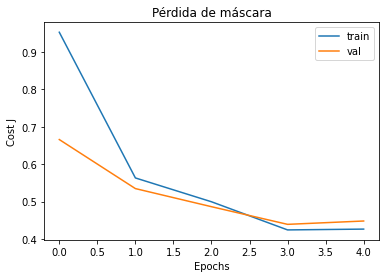

In [ ]:
plt.plot([np.median(i) for i in trn_mask_losses], label='train')
plt.plot([np.median(i) for i in val_mask_losses], label='val')
plt.title('Pérdida de máscara')
plt.ylabel('Cost J')
plt.xlabel('Epochs')
plt.legend()
plt.show()

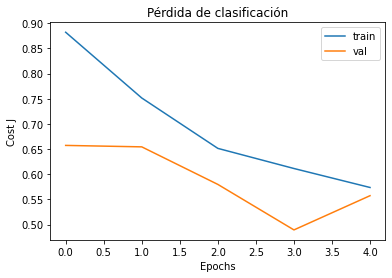

In [ ]:
plt.plot([np.median(i) for i in trn_class_losses], label='train')
plt.plot([np.median(i) for i in val_class_losses], label='val')
plt.title('Pérdida de clasificación')
plt.ylabel('Cost J')
plt.xlabel('Epochs')
plt.legend()
plt.show()

####**2. Análisis Intersección Sobre la Unión (IoU)**

Loading: pytorch_model-e0.bin


  0%|          | 0/7 [00:00<?, ?it/s]

Loading: pytorch_model-e1.bin


  0%|          | 0/7 [00:00<?, ?it/s]

Loading: pytorch_model-e2.bin


  0%|          | 0/7 [00:00<?, ?it/s]

Loading: pytorch_model-e3.bin


  0%|          | 0/7 [00:00<?, ?it/s]

Loading: pytorch_model-e4.bin


  0%|          | 0/7 [00:00<?, ?it/s]

Loading: pytorch_model-e0.bin


  0%|          | 0/22 [00:00<?, ?it/s]

Loading: pytorch_model-e1.bin


  0%|          | 0/22 [00:00<?, ?it/s]

Loading: pytorch_model-e2.bin


  0%|          | 0/22 [00:00<?, ?it/s]

Loading: pytorch_model-e3.bin


  0%|          | 0/22 [00:00<?, ?it/s]

Loading: pytorch_model-e4.bin


  0%|          | 0/22 [00:00<?, ?it/s]

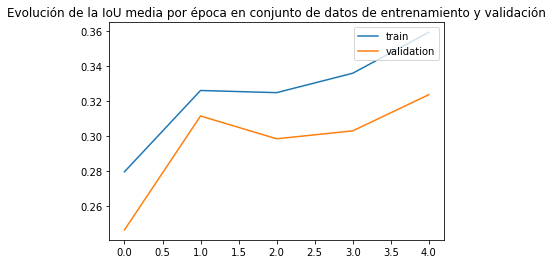

In [ ]:
# Evolución de la IoU media por época en sets
best_epoch_val, val_scores = evaluate_epochs(val_mask_losses, ds_val)
best_epoch_train, train_scores = evaluate_epochs(trn_mask_losses, ds_train)
plt.plot(train_scores['mean_iou'], label="train")
plt.plot(val_scores['mean_iou'], label="validation")
plt.legend(loc="upper right")
plt.title('Evolución de la IoU media por época en conjunto de datos de entrenamiento y validación')  
plt.show()

In [ ]:
#fixing nans
'''
import re
# train
epochs_ious = []
for e in range(train_scores.shape[0]):
  str_all_ious=train_scores.iloc[e]['mean_ious_per_image']
  all_ious = []
  n_images = 0
  for i in re.findall(r"[-+]?(?:\d*\.\d+|\d+)", str_all_ious):
    if i[0] != 'n':
      all_ious.append(float(i))
    else:
      all_ious.append(0.)
    n_images +=1
  epochs_ious.append(all_ious)
train_scores['mean_ious_per_image'] = [str(i) for i in epochs_ious]
train_scores['mean_iou'] = [np.mean(i) for i in epochs_ious]

plt.plot(train_scores['mean_iou'], label="train")
plt.plot(val_scores['mean_iou'], label="validation")
plt.legend(loc="lower right")
plt.title('Evolución de la IoU media por época en conjunto de datos de entrenamiento y validación')  
plt.show()
'''

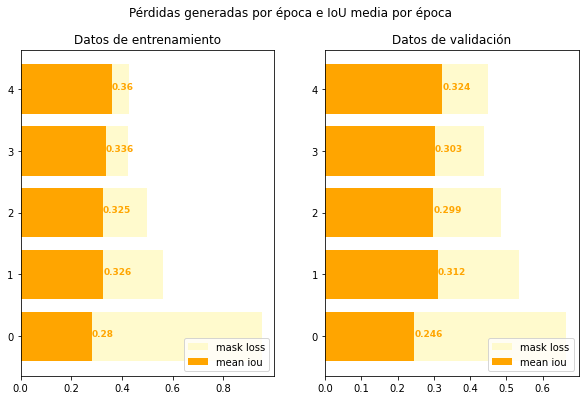

In [ ]:
# Pérdidas generadas por época e IoU media por época
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,6))
fig.suptitle('Pérdidas generadas por época e IoU media por época')
x = np.arange(0,NUM_EPOCHS,1)
# train
ax1.barh(x,train_scores.mask_loss,label='mask loss',color='lemonchiffon')
ax1.barh(x,train_scores.mean_iou, label='mean iou',color='orange')
ax1.set_title('Datos de entrenamiento')
ax1.legend(loc='lower right')
for index in range(len(x)):
  ax1.text(train_scores.mean_iou[index], x[index], round(train_scores.mean_iou[index],3), size=9,color='orange',fontweight = 'bold')
# val
ax2.barh(x,val_scores.mask_loss,label='mask loss',color='lemonchiffon')
ax2.barh(x,val_scores.mean_iou, label='mean iou',color='orange')
ax2.set_title('Datos de validación')
ax2.legend(loc='lower right')
for index in range(len(x)):
  ax2.text(val_scores.mean_iou[index], x[index], round(val_scores.mean_iou[index],3), size=9,color='orange',fontweight = 'bold')

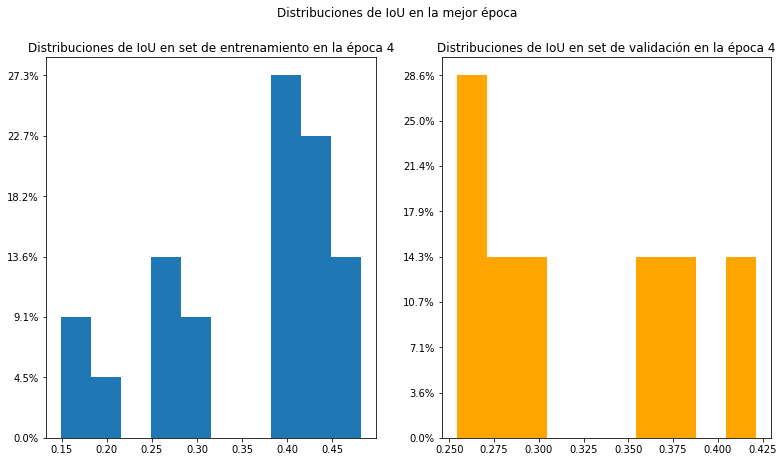

In [ ]:
# Distribuciones de IoU en la mejor época
import re
import matplotlib.ticker as tick

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(13,7))
fig.suptitle('Distribuciones de IoU en la mejor época')
# train
str_all_ious=train_scores.iloc[best_epoch_train]['mean_ious_per_image']
all_ious = []
n_images = 0
for i in re.findall(r"[-+]?(?:\d*\.\d+|\d+)", str_all_ious):
  all_ious.append(float(i))
  n_images +=1

ax1.hist(all_ious)
ax1.set_title(f'Distribuciones de IoU en set de entrenamiento en la época {best_epoch_val}')
ax1.yaxis.set_major_formatter(tick.PercentFormatter(n_images))
ax1.yaxis.set_major_formatter(tick.PercentFormatter(n_images))

# val
str_all_ious=val_scores.iloc[best_epoch_val]['mean_ious_per_image']
all_ious_val = []
n_images_val = 0
for i in re.findall(r"[-+]?(?:\d*\.\d+|\d+)", str_all_ious):
  all_ious_val.append(float(i))
  n_images_val +=1

ax2.hist(all_ious_val, color='orange')
ax2.set_title(f'Distribuciones de IoU en set de validación en la época {best_epoch_val}')
ax2.yaxis.set_major_formatter(tick.PercentFormatter(n_images_val))

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

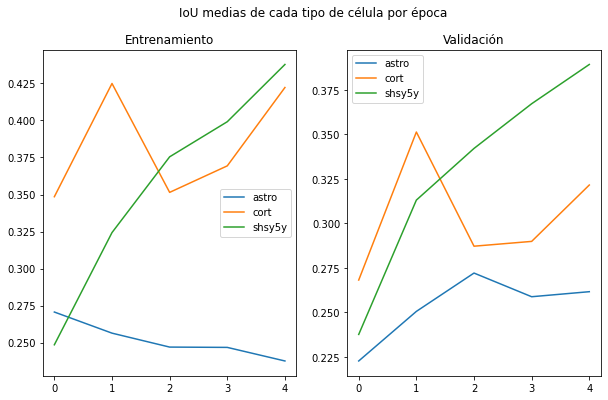

In [ ]:
# Evolución por época de las IoU medias por clase en los sets
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,6))
fig.suptitle('IoU medias de cada tipo de célula por época')

#train
astro_ious_acc = []
cort_ious_acc = []
shsy5y_ious_acc =[]
for i in x:
  astro_ious, cort_ious, shsy5y_ious = iou_class_bylabel(i,ds_train)[:3]
  #fixing nans
  new_shsy5y_ious = []
  [new_shsy5y_ious.append(i) if i>0 else 0. for i in shsy5y_ious]
  astro_ious_acc.append(np.mean(astro_ious))
  cort_ious_acc.append(np.mean(cort_ious))
  shsy5y_ious_acc.append(np.mean(new_shsy5y_ious))

ax1.plot(astro_ious_acc, label="astro")
ax1.plot(cort_ious_acc, label="cort")
ax1.plot(shsy5y_ious_acc, label="shsy5y")
ax1.set_title('Entrenamiento')
ax1.legend()

#val
astro_ious_acc_val = []
cort_ious_acc_val = []
shsy5y_ious_acc_val =[]
for i in x:
  astro_ious, cort_ious, shsy5y_ious = iou_class_bylabel(i,ds_val)[:3]
  #fixing nans
  new_shsy5y_ious = []
  [new_shsy5y_ious.append(i) if i>0 else 0. for i in shsy5y_ious]
  astro_ious_acc_val.append(np.mean(astro_ious))
  cort_ious_acc_val.append(np.mean(cort_ious))
  shsy5y_ious_acc_val.append(np.mean(new_shsy5y_ious))

ax2.plot(astro_ious_acc_val, label="astro")
ax2.plot(cort_ious_acc_val, label="cort")
ax2.plot(shsy5y_ious_acc_val, label="shsy5y")
ax2.set_title('Validación')
ax2.legend()

In [ ]:
# Cálculo de IoU y acierto clase predicha por set y clase
# train
media_ious_class1, media_ious_class2, media_ious_class3,\
class_astro_ratio, class_cort_ratio, class_shsy5y_ratio = iou_class_bylabel(best_epoch_val,ds_train)
# val
media_ious_class1_val, media_ious_class2_val, media_ious_class3_val,\
class_astro_ratio_val, class_cort_ratio_val, class_shsy5y_ratio_val = iou_class_bylabel(best_epoch_val,ds_val)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
print(f'Para la época elegida {best_epoch_val} en entrenamiento, las IoUs por clase son:')
print(f'Para la clase astro la IoU media es de {np.mean(media_ious_class1)}')
print(f'Para la clase cort la IoU media es de {np.mean(media_ious_class2)}')
print(f'Para la clase shsy5y la IoU media es de {np.mean(media_ious_class3)}')
print('')
print(f'Para la época elegida {best_epoch_val} en validación, las IoUs por clase son:')
print(f'Para la clase astro la IoU media es de {np.mean(media_ious_class1_val)}')
print(f'Para la clase cort la IoU media es de {np.mean(media_ious_class2_val)}')
print(f'Para la clase shsy5y la IoU media es de {np.mean(media_ious_class3_val)}')

Para la época elegida 4 en entrenamiento, las IoUs por clase son:
Para la clase astro la IoU media es de 0.2462904155254364
Para la clase cort la IoU media es de 0.42350295186042786
Para la clase shsy5y la IoU media es de 0.4232926666736603

Para la época elegida 4 en validación, las IoUs por clase son:
Para la clase astro la IoU media es de 0.261570006608963
Para la clase cort la IoU media es de 0.3215422034263611
Para la clase shsy5y la IoU media es de 0.38930821418762207


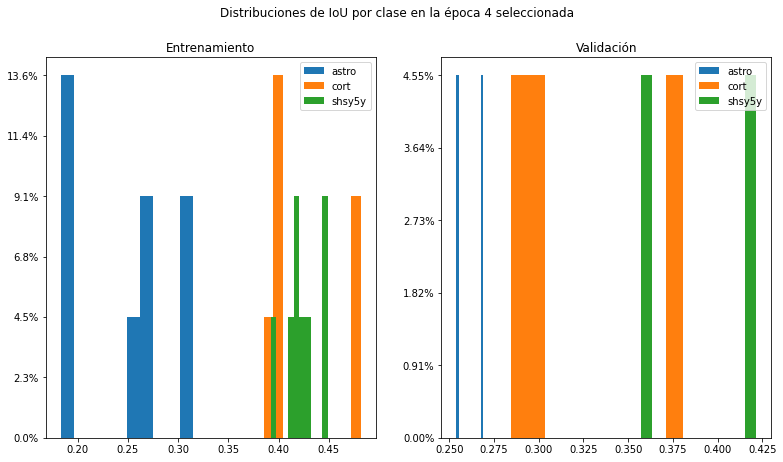

In [ ]:
#Distribución de IoUs medias por clase en la época seleccionada para entrenamiento y validación
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(13,7))
fig.suptitle(f'Distribuciones de IoU por clase en la época {best_epoch_val} seleccionada')
# train
ax1.hist(media_ious_class1, label='astro')
ax1.hist(media_ious_class2, label='cort')
ax1.hist(media_ious_class3, label='shsy5y')
ax1.set_title('Entrenamiento')
ax1.yaxis.set_major_formatter(tick.PercentFormatter(n_images))
ax1.legend()

# val
ax2.hist(media_ious_class1_val, label='astro')
ax2.hist(media_ious_class2_val, label='cort')
ax2.hist(media_ious_class3_val, label='shsy5y')
ax2.set_title('Validación')
ax2.yaxis.set_major_formatter(tick.PercentFormatter(n_images))
ax2.legend()

####**3. Análisis clasificación de células**

In [ ]:
# train
print(f'La media de clases acertadas para astro en entrenamiento es de {np.mean(class_astro_ratio)} sobre 1.')
print(f'La media de clases acertadas para cort en entrenamiento es de {np.mean(class_cort_ratio)} sobre 1.')
print(f'La media de clases acertadas para shsy5y en entrenamiento es de {np.mean(class_shsy5y_ratio)} sobre 1.')
print('')
# val
print(f'La media de clases acertadas para astro en vaildación es de {np.mean(class_astro_ratio_val)} sobre 1.')
print(f'La media de clases acertadas para cort en validación es de {np.mean(class_cort_ratio_val)} sobre 1.')
print(f'La media de clases acertadas para shsy5y en validación es de {np.mean(class_shsy5y_ratio_val)} sobre 1.')

La media de clases acertadas para astro en entrenamiento es de 0.50625 sobre 1.
La media de clases acertadas para cort en entrenamiento es de 0.4166666666666667 sobre 1.
La media de clases acertadas para shsy5y en entrenamiento es de 0.40249999999999997 sobre 1.

La media de clases acertadas para astro en vaildación es de 0.545 sobre 1.
La media de clases acertadas para cort en validación es de 0.48666666666666664 sobre 1.
La media de clases acertadas para shsy5y en validación es de 0.35 sobre 1.


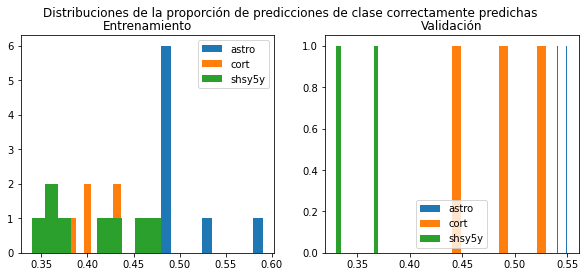

In [ ]:
# Distribuciones de la proporción de predicciones de clase acertadas
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,4))
fig.suptitle('Distribuciones de la proporción de predicciones de clase correctamente predichas')

ax1.hist(class_astro_ratio,label='astro')
ax1.hist(class_cort_ratio,label='cort')
ax1.hist(class_shsy5y_ratio,label='shsy5y')
ax1.set_title('Entrenamiento')
ax1.legend()

ax2.hist(class_astro_ratio_val,label='astro')
ax2.hist(class_cort_ratio_val,label='cort')
ax2.hist(class_shsy5y_ratio_val,label='shsy5y')
ax2.set_title('Validación')
ax2.legend()

####**4. Filtrado métrica IoU>0.5**

In [ ]:
def get_filtered_boxes(pred):
  """
  argumento:
    - pred: resultado de predicción

  función: eliminar las máscaras iguales predichas en una imagen y filtrar los píxeles 
  con menor confianza de ser predichos correctamente.

  devuelve: las máscaras filtradas de la predicción
  """
  labels_acc = []
  use_masks = []   
  use_boxes = []
  for i, mask in enumerate(pred["masks"]):
    # obtengo la probabilidad de la célula de ser predicha correctamente y su clasificación
    scr = pred["scores"][i].cpu().item()
    label = pred["labels"][i].cpu().item()
    if scr > 0.5:
      mask = mask.cpu().numpy().squeeze() #retira el eje de longitud 1
      # elimino los píxeles predichos con menor confianza de ser correctos:
      binary_mask = mask > mask_threshold
      # anulo la máscara si ya está en use_masks:
      binary_mask = remove_overlapping_pixels(binary_mask, use_masks) 
      use_masks.append(binary_mask)
      labels_acc.append(label)
      use_boxes.append(pred['boxes'][i].cpu().numpy())

  return use_masks,labels_acc,use_boxes

In [ ]:
def goodpreds_metrics(e, ds):
  '''
  carga el modelo con la mejor época,
  predice,
  calcula ious y precisión de clasificación
  devuelve: diccionario 
  '''
  model.load_state_dict(torch.load(f"pytorch_model-e{e}.bin"))
  cell_type_dict = {1:"astro", 2:"cort", 3:"shsy5y"}
  class_accuracy_acc = []
  n_cellspreds_acc = []
  original_celltype_acc = []
  original_ncells = []
  for index in range(len(ds)):
    img, targets = ds[index]

    n_truthmasks = len(targets['masks'])
    truthlabel = targets['labels'].unique().item()
    model.eval()
    with torch.no_grad():
          preds = model([img.to(DEVICE)])[0]
      
    filtered_boxes = get_filtered_boxes(preds)
    predmasks_real, predlabel_real, predboxes_real = filtered_boxes
      
    #iou
    ious_de_la_imagen = []
    for number_pred,pred in enumerate(predboxes_real):
      iou_max = 0
      number_truth_chosen = 0
      for number_thruth,truth in enumerate(targets['boxes'].cpu().numpy()):
        iou = get_iou(truth, pred)
        if iou > 0 and iou_max < iou:
          iou_max = iou
      if iou_max > 0:
        ious_de_la_imagen.append(iou_max)
      
    removing_nans = pd.DataFrame(ious_de_la_imagen, columns=['A'])
    removing_nans2 = removing_nans.dropna(subset=['A'])
    iou_mean = removing_nans2['A'].mean()
    #
    pred_masks = combine_masks_pred(filtered_boxes[:2], mask_threshold)
    if len(pred_masks[1]) != 0:
      count_l = pred_masks[1].count(truthlabel)
      accuracy = round(count_l/len(pred_masks[1]),3)
    else:
      accuracy = 0
      
    if len(predmasks_real) > 0:
      original_ncells.append(n_truthmasks)
      original_celltype_acc.append(cell_type_dict[truthlabel])
      n_cellspreds_acc.append(len(predmasks_real))
      class_accuracy_acc.append(accuracy)
  dict_cells = {'truth_number_of_cells': original_ncells, 'truth_cell_type': original_celltype_acc, 'pred_number_of_cells':n_cellspreds_acc, 'pred_accuracy_cell_type':class_accuracy_acc}
  return dict_cells


In [ ]:
import collections
def duplicates(n): #n="123123123"
  counter=collections.Counter(n) #{'1': 3, '3': 3, '2': 3}
  dups=[i for i in counter if counter[i]!=1] #['1','3','2']
  result={}
  for item in dups:
    result[item]=[i for i,j in enumerate(n) if j==item] 
  return result

In [ ]:
# entrenamiento
valid_preds = goodpreds_metrics(best_epoch_val,ds_train)
valid_preds

{'truth_number_of_cells': [108, 36, 42, 34, 247, 33, 360, 36, 360, 360, 360],
 'truth_cell_type': ['astro',
  'cort',
  'cort',
  'cort',
  'shsy5y',
  'astro',
  'shsy5y',
  'cort',
  'shsy5y',
  'shsy5y',
  'shsy5y'],
 'pred_number_of_cells': [2, 1, 1, 1, 6, 1, 28, 1, 3, 3, 3],
 'pred_accuracy_cell_type': [0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]}

In [ ]:
print('Predicciones de entrenamiento:')
print('La mediana de células predichas por imagen (en las imágenes en las que hay predicciones) es de ',np.median(valid_preds['pred_number_of_cells']))
print('')

ratio_ncells = np.median(valid_preds['pred_number_of_cells']) / np.median(valid_preds['truth_number_of_cells'])                                                                   
print('El ratio de células predichas por imagen (en las imágenes en las que hay predicciones) es de ', round(np.median(ratio_ncells),3))
print('')

print('La mediana de las clases predichas por imagen (en las imágenes en las que hay predicciones) es de ',np.median(valid_preds['pred_accuracy_cell_type']))
print('')

Predicciones de entrenamiento:
La mediana de células predichas por imagen (en las imágenes en las que hay predicciones) es de  2.0

El ratio de células predichas por imagen (en las imágenes en las que hay predicciones) es de  0.019

La mediana de las clases predichas por imagen (en las imágenes en las que hay predicciones) es de  1.0



In [ ]:
# división por clase
from operator import truediv

def goodiou_analysis(celltype, valid_preds):
  indexes = duplicates(valid_preds['truth_cell_type'])[celltype]
  n = list(map(valid_preds['pred_number_of_cells'].__getitem__,indexes))
  print(f'La mediana de células {celltype} predichas por imagen (en las imágenes en las que hay predicciones) es de {np.median(n)}')
  ratio_ncells0 = list(map(valid_preds['pred_number_of_cells'].__getitem__,indexes))
  ratio_ncells1 = list(map(valid_preds['truth_number_of_cells'].__getitem__,indexes))
  ratio = list(map(truediv,ratio_ncells0,ratio_ncells1))                                                                  
  print(f'El ratio de células {celltype} predichas por imagen (en las imágenes en las que hay predicciones) es de {round(np.median(ratio),3)}')
  ac = list(map(valid_preds['pred_accuracy_cell_type'].__getitem__,indexes))
  print(f'La mediana de las clases {celltype} predichas por imagen (en las imágenes en las que hay predicciones) es de {np.median(ac)}')
  print('')
  return n,ratio,ac


In [ ]:
goodiou_analysis('astro',valid_preds)

La mediana de células astro predichas por imagen (en las imágenes en las que hay predicciones) es de 1.5
El ratio de células astro predichas por imagen (en las imágenes en las que hay predicciones) es de 0.024
La mediana de las clases astro predichas por imagen (en las imágenes en las que hay predicciones) es de 0.0



([2, 1], [0.018518518518518517, 0.030303030303030304], [0.0, 0.0])

In [ ]:
goodiou_analysis('cort',valid_preds)

La mediana de células cort predichas por imagen (en las imágenes en las que hay predicciones) es de 1.0
El ratio de células cort predichas por imagen (en las imágenes en las que hay predicciones) es de 0.028
La mediana de las clases cort predichas por imagen (en las imágenes en las que hay predicciones) es de 0.5



([1, 1, 1, 1],
 [0.027777777777777776,
  0.023809523809523808,
  0.029411764705882353,
  0.027777777777777776],
 [0.0, 1.0, 0.0, 1.0])

In [ ]:
goodiou_analysis('shsy5y',valid_preds)

La mediana de células shsy5y predichas por imagen (en las imágenes en las que hay predicciones) es de 3.0
El ratio de células shsy5y predichas por imagen (en las imágenes en las que hay predicciones) es de 0.008
La mediana de las clases shsy5y predichas por imagen (en las imágenes en las que hay predicciones) es de 1.0



([6, 28, 3, 3, 3],
 [0.024291497975708502,
  0.07777777777777778,
  0.008333333333333333,
  0.008333333333333333,
  0.008333333333333333],
 [1.0, 1.0, 1.0, 1.0, 1.0])

In [ ]:
# validación
valid_preds_val = goodpreds_metrics(best_epoch_val,ds_val)
valid_preds_val

{'truth_number_of_cells': [298, 95, 34, 423],
 'truth_cell_type': ['shsy5y', 'astro', 'cort', 'shsy5y'],
 'pred_number_of_cells': [23, 1, 1, 46],
 'pred_accuracy_cell_type': [1.0, 0.0, 1.0, 1.0]}

In [ ]:
print('Predicciones de validación:')
print('La mediana de células predichas por imagen (en las imágenes en las que hay predicciones) es de ',np.median(valid_preds_val['pred_number_of_cells']))
print('')

ratio_ncells_val = np.median(valid_preds_val['pred_number_of_cells']) / np.median(valid_preds_val['truth_number_of_cells'])                                                                   
print('El ratio de células predichas por imagen (en las imágenes en las que hay predicciones) es de ', round(np.median(ratio_ncells_val),3))
print('')

print('La mediana de las clases predichas por imagen (en las imágenes en las que hay predicciones) es de ',np.median(valid_preds_val['pred_accuracy_cell_type']))
print('')

Predicciones de validación:
La mediana de células predichas por imagen (en las imágenes en las que hay predicciones) es de  12.0

El ratio de células predichas por imagen (en las imágenes en las que hay predicciones) es de  0.061

La mediana de las clases predichas por imagen (en las imágenes en las que hay predicciones) es de  1.0



In [ ]:
goodiou_analysis('astro',valid_preds_val)

KeyError: ignored

In [ ]:
goodiou_analysis('cort',valid_preds_val)

KeyError: ignored

In [ ]:
goodiou_analysis('shsy5y',valid_preds_val)

La mediana de células shsy5y predichas por imagen (en las imágenes en las que hay predicciones) es de 34.5
El ratio de células shsy5y predichas por imagen (en las imágenes en las que hay predicciones) es de 0.093
La mediana de las clases shsy5y predichas por imagen (en las imágenes en las que hay predicciones) es de 1.0



([23, 46], [0.07718120805369127, 0.10874704491725769], [1.0, 1.0])

####**5. Visualización de células y sus predicciones**

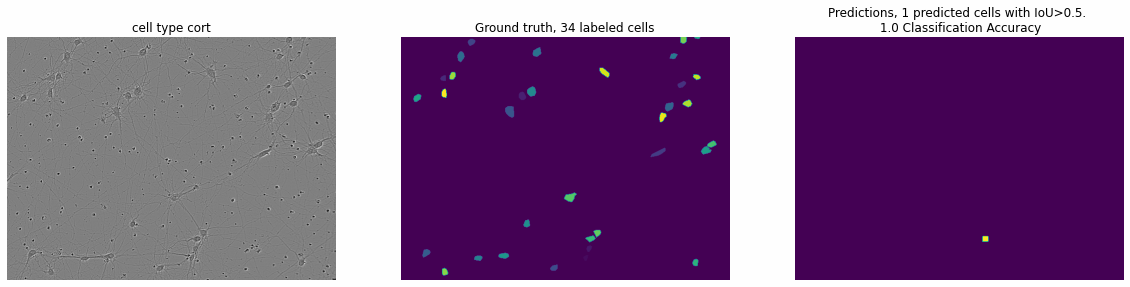

IoU media: 0.3806518


In [ ]:
analyze_train_sample(model, ds_val, 3)

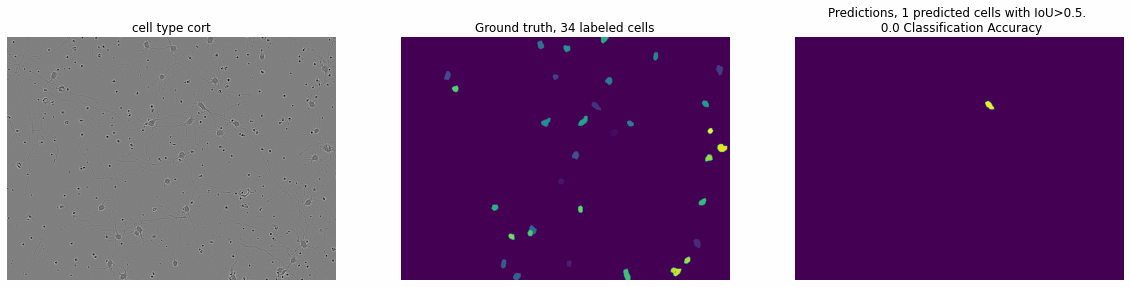

IoU media: 0.4815154


In [ ]:
analyze_train_sample(model, ds_train, 3)

In [ ]:
def visualize_total(model, ds):
  '''
  visualización total del dataset y predicciones
  '''
  cell_type_dict = {1:"astro", 2:"cort", 3:"shsy5y"}
  count = 0
  for i in ds:
    count +=1
    if count == 6:
      break
    img, targets = i
    #print(img.shape)
    l = np.unique(targets["labels"])
    ig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,60), facecolor="#fefefe")
    ax[0].imshow(img.numpy().transpose((1,2,0)))
    ax[0].set_title(f"cell type {cell_type_dict[l[0]]}")
    ax[0].axis("off")
      
    masks = combine_masks(targets['masks'], 0.5)
    #plt.imshow(img.numpy().transpose((1,2,0)))
    ax[1].imshow(masks)
    ax[1].set_title(f"Ground truth, {len(targets['masks'])} labeled cells")
    ax[1].axis("off")
      
    model.eval()
    with torch.no_grad():
      preds = model([img.to(DEVICE)])[0]

    #iou
    ious_de_la_imagen = []
    for number_pred,pred in enumerate(preds['boxes'].cpu()):
      iou_max = 0
      number_truth_chosen = 0
      for number_thruth,truth in enumerate(targets['boxes']):
        iou = get_iou(truth, pred)
        if iou > 0 and iou_max < iou:
          iou_max = iou
      if iou_max > 0:
        ious_de_la_imagen.append(iou_max)
      
    removing_nans = pd.DataFrame(ious_de_la_imagen, columns=['A'])
    removing_nans2 = removing_nans.dropna(subset=['A'])
    iou_mean = removing_nans2['A'].mean()
    #
      
    #labels_pred = list(preds['labels'].cpu().numpy())

    pred_masks = combine_masks_pred(get_filtered_masks(preds), mask_threshold)
    if len(pred_masks[1]) != 0:
      count_l = pred_masks[1].count(l)
      accuracy = round(count_l/len(pred_masks[1]),3)
    else:
      accuracy = 0

    ax[2].imshow(pred_masks[0])
    ax[2].set_title(f"Predictions, {len(pred_masks[1])} predicted cells with IoU>0.5. \n {accuracy} Classification Accuracy")
    ax[2].axis("off")
    plt.show() 
      
    print("IoU media:", iou_mean)  

Visualizaciones de imágenes con máscaras reales y predichas en entrenamiento


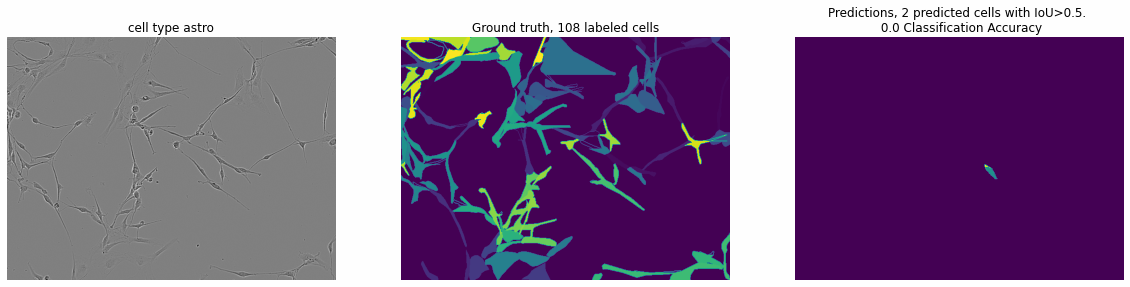

IoU media: 0.3081525


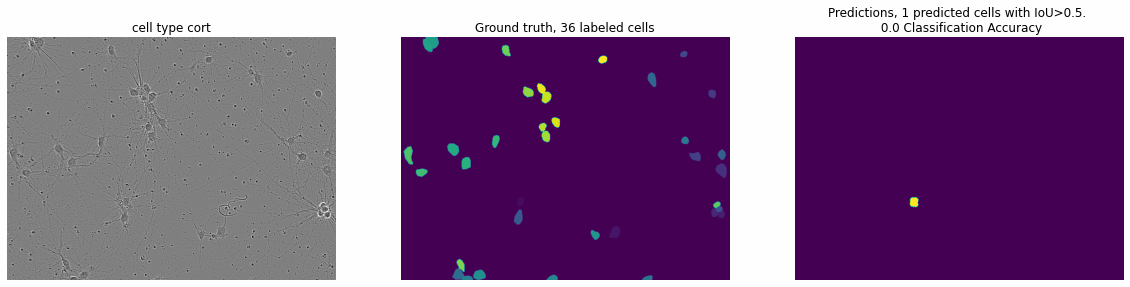

IoU media: 0.38510853


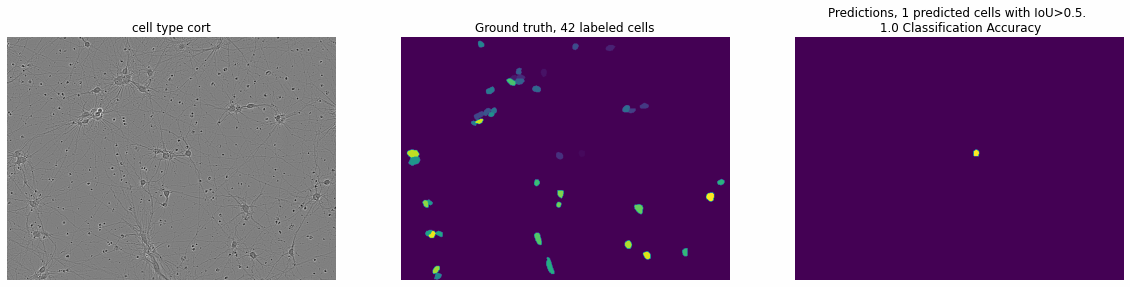

IoU media: 0.39863676


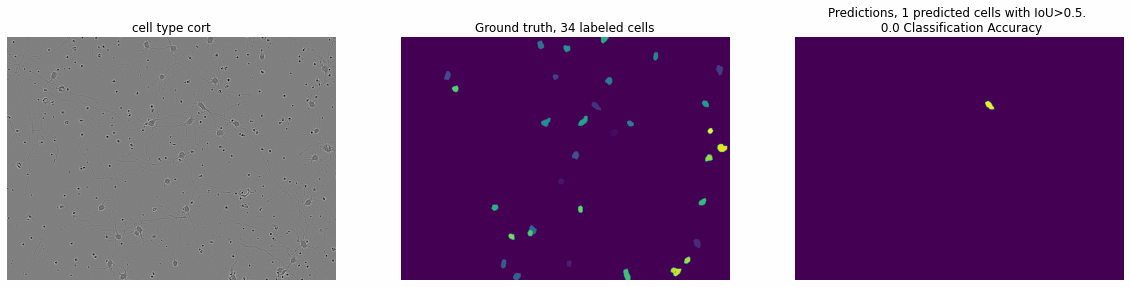

IoU media: 0.4815154


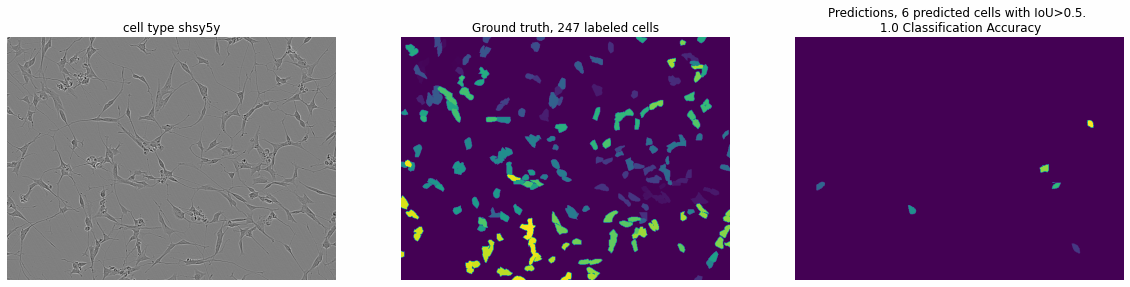

IoU media: 0.40993997


In [ ]:
print('Visualizaciones de imágenes con máscaras reales y predichas en entrenamiento')
visualize_total(model, ds_train)

Visualizaciones de imágenes con máscaras reales y predichas en validación


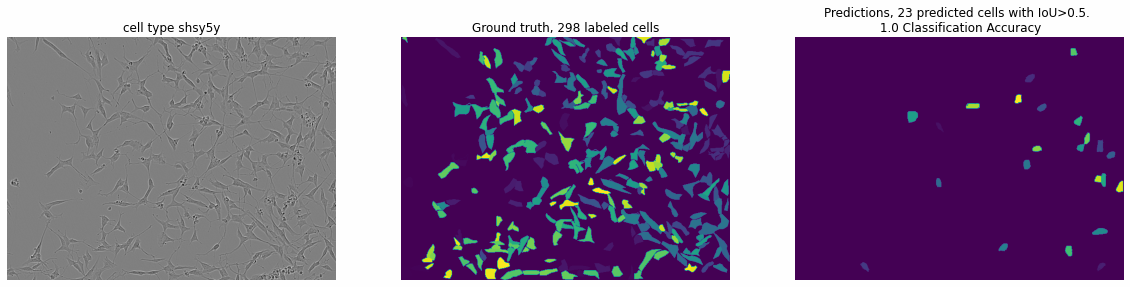

IoU media: 0.35704717


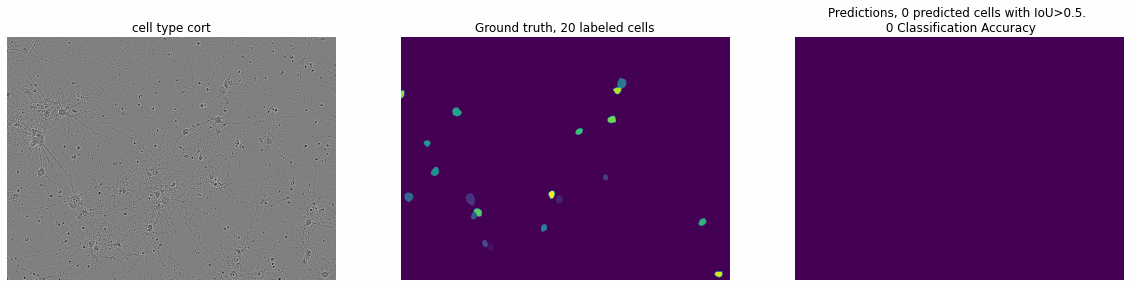

IoU media: 0.29950976


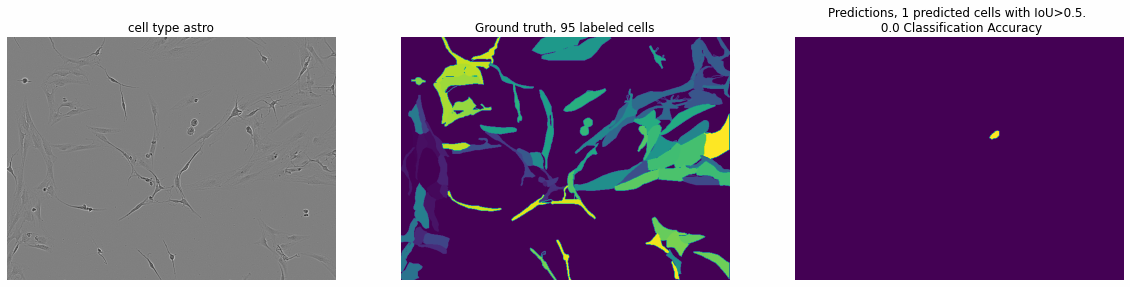

IoU media: 0.26906267


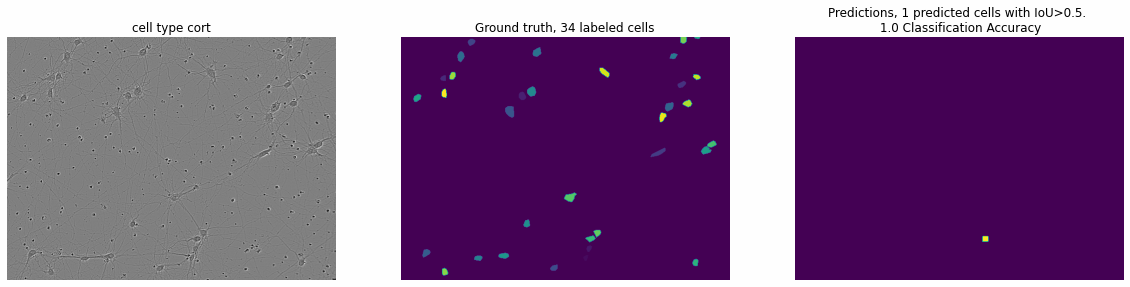

IoU media: 0.3806518


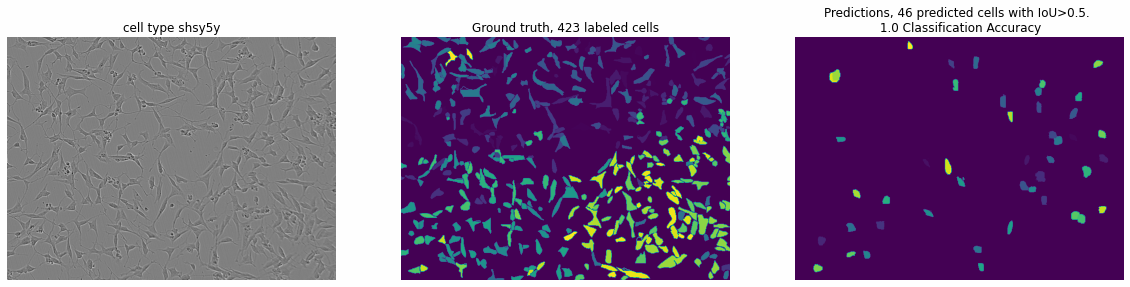

IoU media: 0.42156926


In [ ]:
print('Visualizaciones de imágenes con máscaras reales y predichas en validación')
visualize_total(model, ds_val)

###**Predicción en datos reales, datos test**

In [ ]:
#all_ids_test = df_test.id.unique()
all_ids_test = ['042dc0e561a4', '049f02e0f764', '0c90b86742b2', '0ea6df67cc77', '11c136be56b7', '1395c3f12b7c']
df_test = df_test[df_test.id.isin(all_ids_test)]
dl_test, ds_test = get_data(df_test, batch_size=BATCH_SIZE)

In [ ]:
mean_real_ious, real_ious = iou_set(best_epoch_val,ds_test)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
real_ious_astro, real_ious_cort, real_ious_shsy5y,\
real_class_astro_ratio, real_class_cort_ratio, real_class_shsy5y_ratio = iou_class_bylabel(best_epoch_val,ds_test)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
print(f'La IoU media que genera mi modelo es de {mean_real_ious}')
print('')
print('Por clase:')
print(f'Para la clase astro la IoU media es de {np.mean(real_ious_astro)}')
print(f'Para la clase cort la IoU media es de {np.mean(real_ious_cort)}')
print(f'Para la clase shsy5y la IoU media es de {np.mean(real_ious_shsy5y)}')

La IoU media que genera mi modelo es de 0.3547933101654053

Por clase:
Para la clase astro la IoU media es de 0.31514430046081543
Para la clase cort la IoU media es de 0.38047468662261963
Para la clase shsy5y la IoU media es de 0.3570471704006195


In [ ]:
total_class = (np.mean(real_ious_astro) + np.mean(real_ious_cort) + np.mean(real_ious_shsy5y)) /3
print(f'La precisión de clase (acertadas) que genera mi modelo es de {total_class}')
print('')
print('Por clase:')
print(f'Para la clase astro la precisión de clase es de {np.mean(real_class_astro_ratio)}')
print(f'Para la clase cort la precisión de clase es de {np.mean(real_class_cort_ratio)}')
print(f'Para la clase shsy5y la precisión de clase es de {np.mean(real_class_shsy5y_ratio)}')

La precisión de clase (acertadas) que genera mi modelo es de 0.350888729095459

Por clase:
Para la clase astro la precisión de clase es de 0.31514430046081543
Para la clase cort la precisión de clase es de 0.38047468662261963
Para la clase shsy5y la precisión de clase es de 0.3570471704006195


In [ ]:
real_preds = goodpreds_metrics(best_epoch_val, ds_test)

In [ ]:
print('La mediana de células predichas por imagen (en las imágenes en las que hay predicciones) es de ',np.median(real_preds['pred_number_of_cells']))
print('')
 
ratio_ncells_real = np.median(real_preds['pred_number_of_cells']) / np.median(real_preds['truth_number_of_cells'])                                                                  
print('El ratio de células predichas por imagen (en las imágenes en las que hay predicciones) es de ', round(np.median(ratio_ncells_real),3))
print('')
 
print('La mediana de las clases predichas por imagen (en las imágenes en las que hay predicciones) es de ',np.median(real_preds['pred_accuracy_cell_type']))
print('')

La mediana de células predichas por imagen (en las imágenes en las que hay predicciones) es de  1.0

El ratio de células predichas por imagen (en las imágenes en las que hay predicciones) es de  0.011

La mediana de las clases predichas por imagen (en las imágenes en las que hay predicciones) es de  1.0



In [ ]:
goodiou_analysis('cort', real_preds)

La mediana de células cort predichas por imagen (en las imágenes en las que hay predicciones) es de 1.0
El ratio de células cort predichas por imagen (en las imágenes en las que hay predicciones) es de 0.029
La mediana de las clases cort predichas por imagen (en las imágenes en las que hay predicciones) es de 1.0



([1, 1], [0.02631578947368421, 0.03225806451612903], [1.0, 1.0])

In [ ]:
goodiou_analysis('shsy5y', real_preds)

KeyError: ignored

In [ ]:
goodiou_analysis('astro', real_preds)

La mediana de células astro predichas por imagen (en las imágenes en las que hay predicciones) es de 1.0
El ratio de células astro predichas por imagen (en las imágenes en las que hay predicciones) es de 0.011
La mediana de las clases astro predichas por imagen (en las imágenes en las que hay predicciones) es de 0.0



([1, 1], [0.011235955056179775, 0.010526315789473684], [0.0, 0.0])

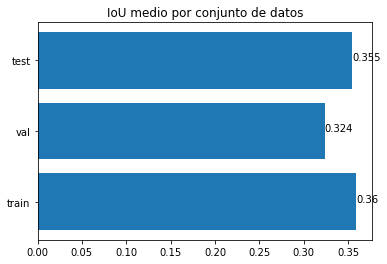

In [ ]:
plt.barh(['train','val','test'],[train_scores.mean_iou[4], 
                                 val_scores.mean_iou[4], 
                                 mean_real_ious])
plt.title('IoU medio por conjunto de datos')

for index, value in enumerate([train_scores.mean_iou[4], 
                                 val_scores.mean_iou[4], 
                                 mean_real_ious]):
    plt.text(value, index, str(round(value,3)))

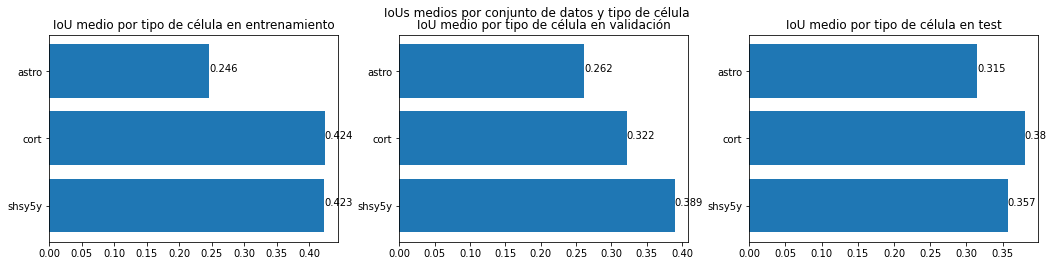

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(15,4))
fig.tight_layout(pad=3.0)
fig.suptitle('IoUs medios por conjunto de datos y tipo de célula')

ax1.barh(['shsy5y','cort','astro'],[np.mean(media_ious_class3), 
                                    np.mean(media_ious_class2), 
                                    np.mean(media_ious_class1)])
ax1.set_title('IoU medio por tipo de célula en entrenamiento')

for index, value in enumerate([np.mean(media_ious_class3), 
                                    np.mean(media_ious_class2), 
                                    np.mean(media_ious_class1)]):
    ax1.text(value, index, str(round(value,3)))

ax2.barh(['shsy5y','cort','astro'],[np.mean(media_ious_class3_val), 
                                    np.mean(media_ious_class2_val), 
                                    np.mean(media_ious_class1_val)])
ax2.set_title('IoU medio por tipo de célula en validación')

for index, value in enumerate([np.mean(media_ious_class3_val), 
                                    np.mean(media_ious_class2_val), 
                                    np.mean(media_ious_class1_val)]):
    ax2.text(value, index, str(round(value,3)))

ax3.barh(['shsy5y','cort','astro'],[np.mean(real_ious_shsy5y), 
                                    np.mean(real_ious_cort), 
                                    np.mean(real_ious_astro)])
ax3.set_title('IoU medio por tipo de célula en test')

for index, value in enumerate([np.mean(real_ious_shsy5y), 
                                    np.mean(real_ious_cort), 
                                    np.mean(real_ious_astro)]):
    ax3.text(value, index, str(round(value,3)))

Visualizaciones de imágenes con máscaras reales y predichas en test


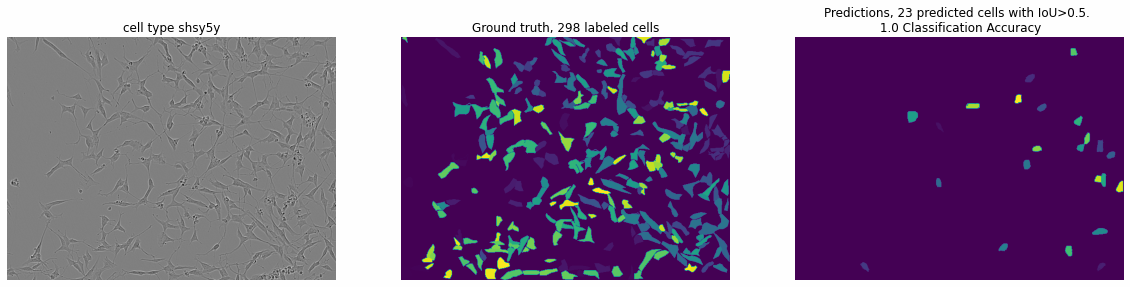

IoU media: 0.35704717


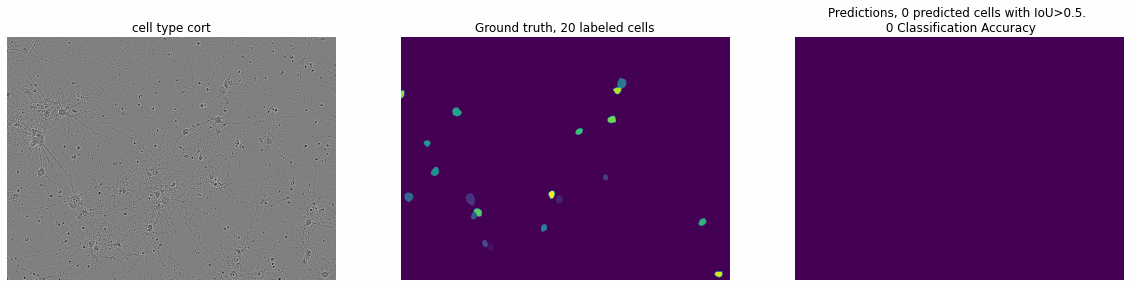

IoU media: 0.29950976


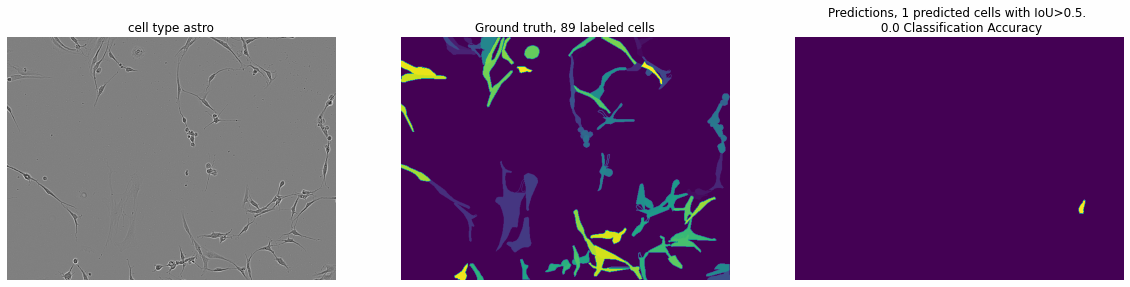

IoU media: 0.36122593


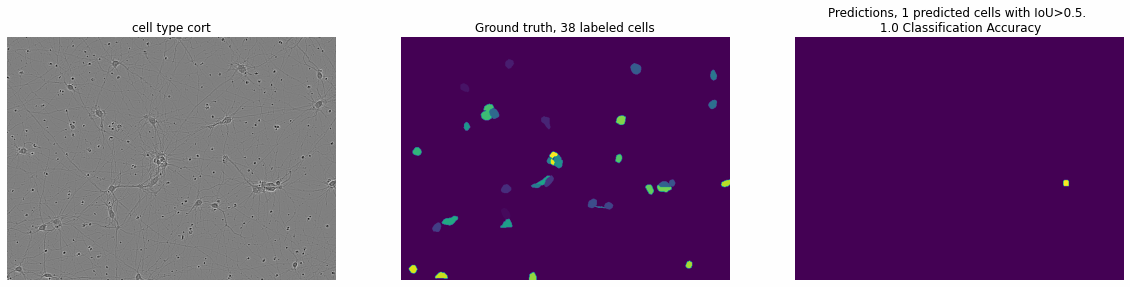

IoU media: 0.42584255


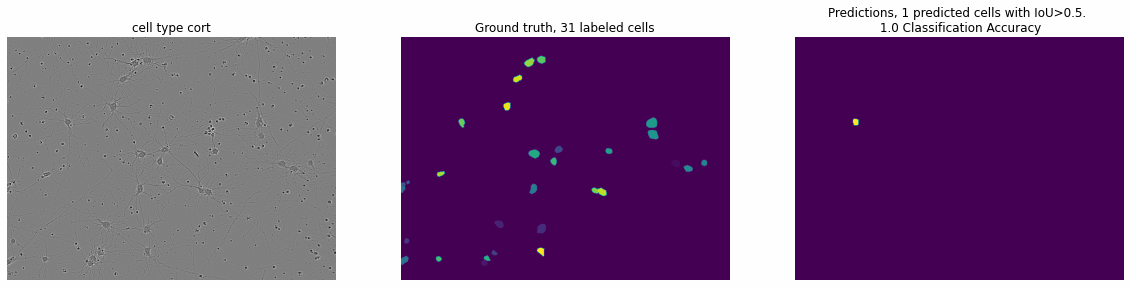

IoU media: 0.41607174


In [ ]:
print('Visualizaciones de imágenes con máscaras reales y predichas en test')
visualize_total(model, ds_test)